In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3 * x**2 - 4*x + 5

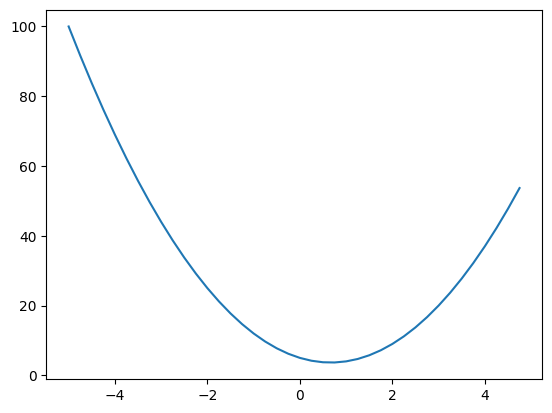

In [3]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [4]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
        
    def tanh(self):
        x = self.data
        # 计算 tanh 的数值
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            # tanh(x) 的导数是 1 - tanh(x)^2
            # 这里的 t 就是 tanh(x)
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
        
a = Value(2.0)
b = Value(3.0)
c = a + b
d = a * b + Value(10)
d

Value(data=16.0, grad=0)

In [5]:
d._prev

{Value(data=10, grad=0), Value(data=6.0, grad=0)}

In [6]:
d._op

'+'

In [7]:
from graphviz import Digraph

In [8]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [9]:
d.backward()

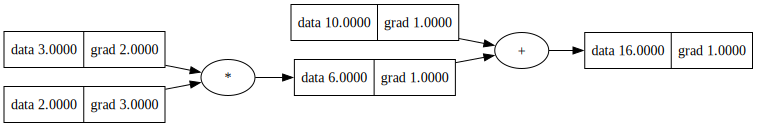

In [10]:
draw_dot(d)

In [11]:
import random
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        act = sum((wi * xi for wi,xi in zip(self.w,x)),self.b) 
        out = act.tanh()
        return out
    def parameters(self):
         return self.w + [self.b]

x = [2.0,3.0]
n = Neuron(2)
n(x)
        

Value(data=0.388569719946169, grad=0)

In [12]:
class Layer:
     def __init__(self,nin,nout):
         self.neurons = [Neuron(nin) for _ in range(nout)]
     def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
     def parameters(self):
         params = []
         for neuron in self.neurons:
             ps = neuron.parameters()
             params.extend(ps)
         return params
x = [2.0,3.0]
n = Layer(2,3)
n(x)

[Value(data=0.24573822882923968, grad=0),
 Value(data=-0.9128353372340612, grad=0),
 Value(data=-0.7951232668199905, grad=0)]

In [13]:
class MLP:
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
         params = []
         for layer in self.layers:
             ps = layer.parameters()
             params.extend(ps)
         return params


In [14]:
x = [2, 3, -1]
n = MLP(3,[4, 4, 1])
out = n(x)

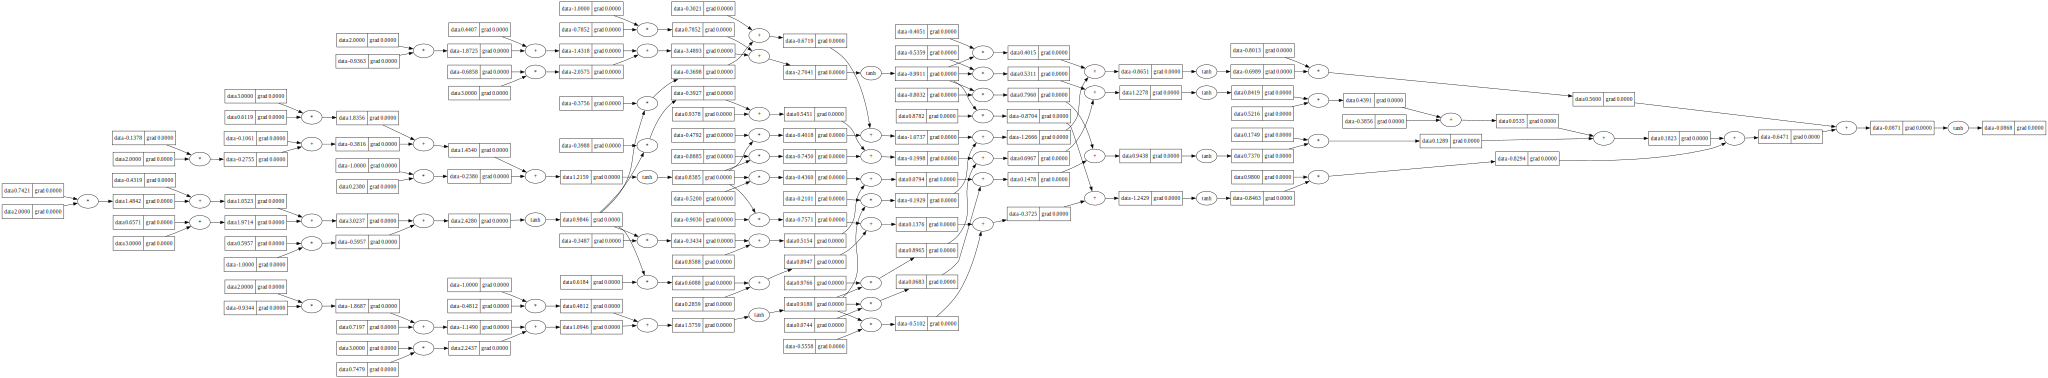

In [15]:
draw_dot(out)

In [16]:
n = MLP(3,[4, 4, 1])

In [17]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [32]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip (ys,ypred))
    
    for p in n.parameters():
        p.grad = 0
        
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.01 * p.grad
        
    print(k,loss.data)

0 0.0526314105486287
1 0.05173178501227052
2 0.05086233470812978
3 0.05002155049872439
4 0.04920802304119587
5 0.0484204346369761
6 0.04765755186853936
7 0.04691821893600366
8 0.04620135161721027
9 0.04550593178427295
10 0.04483100241768335
11 0.04417566306607573
12 0.04353906570584
13 0.04292041096007366
14 0.042318944640984145
15 0.04173395458388622
16 0.041164767744476694
17 0.040610747534165305
18 0.04007129137096523
19 0.03954582842584344


In [33]:
ypred

[Value(data=0.9134340740056396, grad=-0.17313185198872083),
 Value(data=-0.9692266352986831, grad=0.061546729402633726),
 Value(data=-0.8432809688103854, grad=0.3134380623792292),
 Value(data=0.9191030645170616, grad=-0.16179387096587683)]